$
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
$

# Neural Networks - Classification (Workbook)

### ITCS 4156
### Minwoo "Jake" Lee

# Goal

The goal of this activity is to implement neural networks for nonlinear classification and apply it to [Abalone data](https://archive.ics.uci.edu/ml/datasets/Abalone). We will measure how well our neural network does when be compared to a linear classifier.Follow the TODO titles and comments to finish the activity! 

# Agenda

1. Data Loading, Preprocessing, and Visualization
    * Downloading
    * Data Visualization
    * Data Preprocessing
2. Apply Linear Classification: Linear Logistic Classification
3. Apply Nonlinear Classification: Neural Networks

In [80]:
from copy import deepcopy as copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from IPython.core.debugger import set_trace

%matplotlib inline

# Loading, Preprocessing, and Visualization

The dataset we'll be using this week is the Abalone Dataset (pronounced ab·​a·​lo·​ne). For those that don't know, abalone are marine snails. The original goal of this data is to predict the age of a given abalone. Typically, this is done by counting the number of rings the shell contains (much like tree ring counting). However, counting the rings of an abalone shell is expensive (see description below). Thus, the authors of the data wish to use other features to predict age. 

> Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

**It turns out that predicting age is actually quite hard, so we'll focus on predicting other features such as sex. More on this later...**

## Downloading

### Windows Users
Download the data simply by following this link:  https://archive.ics.uci.edu/ml/datasets/Abalone. Be sure to download the 'abalone.data' and 'abalone.names' files. In addition, make sure you put both files in the same directory as this notebook!

### Linux/Mac Users
Like always, if you have Linux or Mac uncomment the below lines to automatically down the data and names files. In addition, the below code will also print out the contents of the 'abalone.names' file.

In [81]:
# !curl -o abalone.data https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
# !curl -o abalone.names https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names
# !cat abalone.names

The 'abalone.data' file does not include the headers in the csv. So, we'll manually create the header names below. Passing the 'names' parameter when creating a DataFrame will manually set our headers. These headers are taken from the data description in the 'abalone.names' files.

In [82]:
names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]

In [83]:
abalone_df = pd.read_csv("abalone.data", names=names)
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Below is the descriptions of our features found in the 'abalone.names' files.

    Sex		    nominal			M, F, and I (infant)
    Length		continuous	mm	Longest shell measurement
    Diameter	continuous	mm	perpendicular to length
    Height		continuous	mm	with meat in shell
    Whole weight	continuous	grams	whole abalone
    Shucked weight	continuous	grams	weight of meat
    Viscera weight	continuous	grams	gut weight (after bleeding)
    Shell weight	continuous	grams	after being dried
    Rings		integer			+1.5 gives the age in years

## Data Visualization

### Scatter matrix

Let's do a quick Pandas `scatter_matrix()` plot to see how our features correlate with one another and the data distribution of each feature.

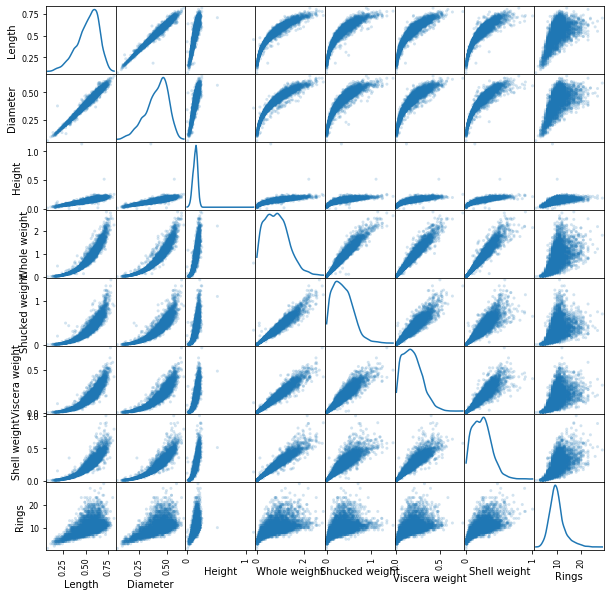

In [84]:
from pandas.plotting import scatter_matrix

scatter_matrix(abalone_df, alpha=0.2, figsize=(10,10), diagonal='kde');

Once again using a scatter matrix we can see every feature plotted against all other features. Recall that unlike most correlation plots the main diagonal for our `scatter_matrix()` function is not a given feature plotted against itself. Instead, the `scatter_matrix()` function produces a more useful plot, the data distribution of each feature. Data distributions are useful to see how spread our data values are for each feature.


On the off-diagonal we can see the plots for features plotted against each other (each side of the off-diagonal is essentially a reflection of the other side). Here we can look for correlations between features just like normal correlation plots. Notice, the correlation between most features forms nonlinear curve instead of a linear line. This might indicate to us that our data is nonlinear and will require a nonlinear algorithm.

### Taking a closer look at data distributions 

Let's take a closer look at the data distributions. Here we'll group our features together into groups with common qualities. The first group will be shell weights consisting of 'Whole weight', 'Shucked weight', 'Viscera weight', and 'Shell weight'. The second group will be shell dimensions consisting of  'Length', 'Diameter', and 'Height'. The third group will simply be shell rings which corresponds to the 'Rings' column. For now, we'll ignore the 'Sex' column as it currently contains categorical variables.

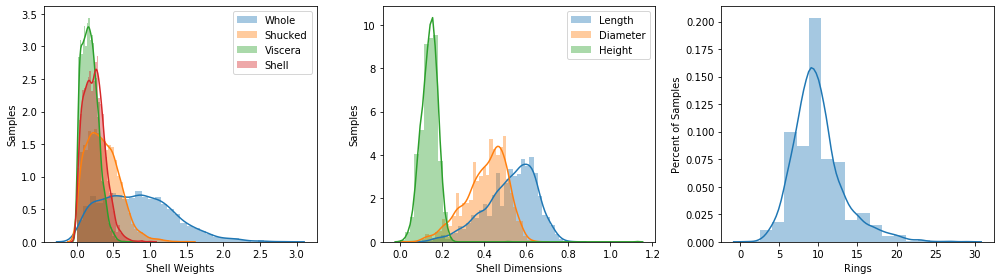

In [85]:
# codes from https://charlesreid1.github.io/circe/Abalone%20-%20Exploring%20the%20Data.html
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Plot weight information
sns.distplot(abalone_df['Whole weight'],   label='Whole',   ax=ax1)
sns.distplot(abalone_df['Shucked weight'], label='Shucked', ax=ax1)
sns.distplot(abalone_df['Viscera weight'], label='Viscera', ax=ax1)
sns.distplot(abalone_df['Shell weight'],   label='Shell',   ax=ax1)
ax1.legend()
ax1.set(xlabel='Shell Weights', ylabel='Samples')

# Plot dimension information
sns.distplot(abalone_df['Length'],   label='Length', ax=ax2)
sns.distplot(abalone_df['Diameter'], label='Diameter', ax=ax2)
sns.distplot(abalone_df['Height'],   label='Height', ax=ax2)
ax2.legend()
ax2.set(xlabel='Shell Dimensions', ylabel='Samples')

# Plot system response
sns.distplot(abalone_df['Rings'], bins=18, ax=ax3)
ax3.set(ylabel='Percent of Samples')
plt.tight_layout()

In the first two graphs we can see how each groups' feature distributions overlap. Recall, that for a data distribution the y-axis represents the number of samples or percent of samples and the x-axis represents the actual feature values.

Looking at the shell weights group plot we can see that most of the feature values are clustered between 0 and 1. However, it does seem that the 'Whole weight' feature has quite a broader distribution. 

The same idea applies to the feature grouping of shell dimensions. We can observe here that the 'Diameter' and 'Height' features do overlap some. Meanwhile, 'Height' seems to be concentrated around the value of .1.

Lastly lets take a look at the ring feature distribution graph to see if it will make a good target. Here we can see that shells with 5 rings only make up 2% of the data samples, while shells with 10 rings make up 20% of the data samples. Typically, we want all our targets to have the same number of data samples, or close to the same number, so our algorithm isn't biased towards a target that has more data samples. Let's take a closer look to see how biased our results might be if we use the ring feature as our target.

### Taking a closer look at our rings feature

Let's take a closer look at the rings feature by printing out the total number of data samples for each of our ring counts. 

Here we extract and visualize our unique ring values.

In [86]:
np.sort(abalone_df['Rings'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

Now we print out 'Ring' column and the number of samples each value has by using the Pandas DataFrame `value_count()` method. Notice how `value_count()` has already sorted our data in descending order according to the number of samples per each unique ring value. 

In [87]:
abalone_df['Rings'].value_counts()

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
24      2
27      2
1       1
25      1
2       1
26      1
29      1
Name: Rings, dtype: int64

Wow, above we can confirm that the ring data distribution is quite spread, as previously observed. In fact, our ring feature data distribution is so spread some ring counts only contain 1 data sample! This is good sign that if we use the ring feature as our target, then our model will be biased towards rings counts that have many samples. For instance, our algorithm will be more likely to predict ring counts of 9, 10, and 8 because it will have seen way more of their samples.

What if we only look at ring counts which have over 100 samples? Will truncating our ring targets lessen the bias? Let's see!

In [88]:
more_than_100_samples = abalone_df['Rings'].value_counts() > 100
abalone_df['Rings'].value_counts()[more_than_100_samples]

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
Name: Rings, dtype: int64

Welp, this gives us 11 target classes now. Still the spread of data distribution is high and thus the bias is still their. Typically, in this scenario we have to compensate for our imbalanced by changing the data or adjusting our algorithm to account for the bias. If we wanted to account for data imbalance at the level of our data we could downsample or upsample our data. Likewise, if we want to account for bias at the level of the algorithm we could apply some form of algorithmic weighting to emphasis minority classes. We'll just quickly elaborate on downsampling and upsampling as it is the most straightforward.

Downsampling means we randomly sample, samples from each target. The amount in which we sample corresponds to the target with the least amount of samples. For instance, our target with the least amount of samples is the ring count of 15 here. This means we would downsample the rest of targets to only have 103 samples.

Upsampling applies the same idea but in the reverse direction. Once again we randomly sample, samples from each target. The amount in which we sample now corresponds to the target with the most samples. Here our target with the most samples is the ring count of 9. This means we upsample the rest of our targets to have 689 samples. In practice, we duplicate the samples or augment existing samples of targets that have lower sample counts until they reach the desired sample count.

Both of these data compensation methods have their pros and cons. However, accounting for a imbalanced and bias data is out of scope for this lab. Let's instead choose a much easier classification feature like 'Sex'! If you have any questions about dealing with imbalanced and biased datasets feel free to ask!

## Data Preprocessing

Let's go ahead an do our classic data processing by splitting the data into training features `X` and target feature `T`.

In [89]:
X = abalone_df.iloc[:, 1:].copy()
T = abalone_df[['Sex']].copy()

In [90]:
X

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [91]:
T

,Sex
0,M
1,M
2,F
3,M
4,I
...,...
4172,F
4173,M
4174,M
4175,F


Recall, that sex is a a categorical variable so we need to convert it to indicator variable.

In [92]:
Ti = pd.get_dummies(T['Sex'])
Ti

,F,I,M
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
...,...,...,...
4172,1,0,0
4173,0,0,1
4174,0,0,1
4175,1,0,0


### Data Partitioning

Do you remember the `partitionlib.py` Python file for data partitioning we saved last week? Well, it's time to reuse it! Let's copy the `partitionlib.py` Python file into the directory where this notebook is running! If you don't have this file go to the [Files](https://uncc.instructure.com/courses/119993/files?preview=8006250) tab in Canvas to download the `partitionlib.py` Python file. 

In [93]:
import partitionlib as ptl

In [94]:
# just in case, you made change in the file, you may need to reload as below
import importlib
import partitionlib
importlib.reload(partitionlib);

In [95]:
def partition_data(X, T):
    """Partition data into train and test splits."""
    data, targets = ptl.partition(copy(X.values), copy(T.values))
    Xtrain, Xtest = data
    Ttrain, Ttest = targets
    return Xtrain, Xtest, Ttrain, Ttest

In [96]:
Xtrain, Xtest, Ttrain, Ttest = partition_data(X, Ti)
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))

Train data shape: (3342, 8)
Train target shape: (3342, 3)
Test data shape: (835, 8)
Test target shape: (835, 3)


In [97]:
N, D = X.shape
Ntrain, Ntest = Xtrain.shape[0], Xtest.shape[0]
print("Number of total samples: {}".format(N))
print("Number of total features: {}".format(D))
print("Number of training samples: {}".format(Ntrain))
print("Number of testing samples: {}".format(Ntest))

Number of total samples: 4177
Number of total features: 8
Number of training samples: 3342
Number of testing samples: 835


### Standardize
Don't forget, we still need to standardize our data! Let's do so now. 

$$\frac{X - mean(X)}{STD(X)}$$

#### TODO: 
1. Complete the `standardize()` function by computing the mean of the passed data `X`.
2. Complete the `standardize()` function by computing the STD of the passed data `X`
3. Compute the standardization of the passed data `X` and return it.

In [98]:
def standardize(X):
    # TODO (1)
    mean = 
    # TODO (2)
    std = 
    # TODO (3)
    return 

In [99]:
XtrainS = standardize(Xtrain)
XtestS = standardize(Xtest)

In [100]:
pd.DataFrame(XtrainS).describe()

,0,1,2,3,4,5,6,7
count,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03
mean,7.419027e-15,-2.218798e-14,9.401616e-15,-2.227090e-15,2.348809e-15,-1.626467e-15,9.567452e-17,-2.104839e-16
std,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00
min,-3.505280e+00,-3.248010e+00,-3.298467e+00,-1.683633e+00,-1.613329e+00,-1.639054e+00,-1.706605e+00,-2.460202e+00
25%,-6.370518e-01,-6.006721e-01,-5.895621e-01,-7.871114e-01,-7.765406e-01,-7.943115e-01,-7.868278e-01,-6.128394e-01
50%,1.643650e-01,1.629832e-01,1.171089e-01,-5.958072e-02,-1.163329e-01,-9.111999e-02,-3.297107e-02,2.948115e-03
75%,7.548827e-01,7.229971e-01,5.882229e-01,6.493150e-01,6.495979e-01,6.611579e-01,6.343184e-01,3.108419e-01
max,2.442076e+00,2.453949e+00,2.331947e+01,4.070241e+00,4.453384e+00,5.283272e+00,5.521763e+00,5.852930e+00


# Classification with Linear Logistic Regression

Recall that the linear logistic regression update is as follows.
$$
\wv \leftarrow \wv + \alpha \Xm^\top \Big(  \Tm - g(\Xm)\Big).
$$

Also recall that the softmax equation is as follows.


$$
 softmax = {P(T = k | x)} = \frac{e^{z_k}}{\sum_{i=1}^K e^{z_i}}
$$

Here $z$ represents our predictions made by computing $X \cdot w$, which will be calculated by the function `g()`.


### TODO: 

**`softmax()` TODO**

1. Using Numpy's `np.exp()` function compute the numerator of the softmax function. To do so apply the exponential function to all our predictions `z`.
<br><br>
2. Compute the denominator of the softmax function. To do so sum over the exponential function applied to all our predictions `z`.
    1. Hint: If you're getting broadcasting errors make sure the numerator and denominator have the same shapes! 
    2. See this [Piazza post](https://piazza.com/class/k5ckxp40u5r5rx?cid=74) if you are struggling with summing over the correct dimension and outputing th correct shape for denominator.
    3. See lab [4-LogisticRegression](https://uncc.instructure.com/courses/119993/files/7907309?module_item_id=2290999) where we originally implemented this function.
<br><br>
3. Return the softmax output calculated inside `softmax()` function.
    1. Hint: Simply divide the numerator by the denominator
<br><br>
4. Call the `softmax()` function and passig our predictions. Recall, predictions are calculated from dotting `X` and `w`. Lastly, return the output of the `softmax()` function.

**`llr_train()` TODO**
1. Compute the class probabilities by calling the `g()` function and passing the required parameters.
<br><br>
2. Compute the linear logistic regression weight update for `w` using the above formula. Remember to use our train data with bias added `X1train` and our indicator variable targets `Titrain`.

In [101]:
def softmax(z):
    if not isinstance(z, np.ndarray):
        z = np.asarray(z)
    # TODO (1)
    numerator = 
    # TODO (2)
    denominator = 
    # TODO (3)
    return 

# Wrapper for softmax
def g(X, w):
    # TODO (4)
    return 

# add ones' column for bias
def addOnes(A):
    return np.insert(A, 0, 1, axis=1)


# linear logistic regression train functio
def llr_train(Xtrain, Titrain, **params): 
    
    # Set shape parameters
    Ntrain, D = Xtrain.shape
    Ntest = Xtest.shape[0]
    K = Titrain.shape[1]

    # initialize the weight matrix
    w = np.random.rand(D+1, K)
    
    # iterate to update weights
    niter = params.pop('niter', 1000)
    alpha = params.pop('alpha', 0.1)

    # Add bias to data
    X1train = addOnes(Xtrain)

    likeli = []
    for step in range(niter):
        # TODO (1)
        ys = 
        # TODO (2)
        w =

    return w

# linear logistic regression test function
def llr_test(Xtest):
    # Add bias to test data
    X1test = addOnes(Xtest)
    # Get class probabilities for each sample in X1test
    return g(X1test, w)
    

In [102]:
w = llr_train(XtrainS, Ttrain, alpha=0.001)
w

array([[ 0.62364068,  0.92183608,  1.04889894],
       [ 0.7006234 ,  1.21782305, -1.14727606],
       [ 2.93935747, -1.06893747,  0.82625323],
       [ 1.58382108, -0.33976977,  0.04977537],
       [ 2.172394  , -0.92262153, -0.09091161],
       [-0.20576046,  0.48559863,  0.95568654],
       [ 2.08581807, -0.77549593,  0.48496394],
       [ 0.45921276,  0.88043177, -0.57433194],
       [ 1.27911848, -0.46199908,  0.59564405]])

In [103]:
Ytrain = llr_test(XtrainS)
Ytrain

array([[2.66290555e-08, 8.43716196e-01, 1.56283777e-01],
       [4.98487165e-08, 9.13325986e-01, 8.66739639e-02],
       [9.99994924e-01, 1.25299815e-07, 4.95100168e-06],
       ...,
       [9.99971952e-01, 2.30767502e-06, 2.57402382e-05],
       [9.98160987e-01, 3.96307877e-04, 1.44270556e-03],
       [2.26958609e-03, 7.46156901e-01, 2.51573513e-01]])

In [104]:
Ytest = llr_test(XtestS)
Ytest

array([[1.06162409e-04, 8.23515421e-01, 1.76378416e-01],
       [9.99876235e-01, 1.95081379e-05, 1.04256725e-04],
       [8.18758011e-02, 7.09535599e-01, 2.08588600e-01],
       ...,
       [3.18441157e-03, 6.69353004e-01, 3.27462585e-01],
       [4.54665583e-01, 3.32140053e-01, 2.13194364e-01],
       [6.37448877e-03, 4.64458986e-01, 5.29166525e-01]])

Now let's get the labels for both the train and test predictions. Remember that we can get the predicted labels by taking the argmax for each row in our data. The idea behind argmax is to return the column index that contains the highest probability. Argmax works great here because our column indices are synonymous with our class targets, this is only because our targets are formatted as indicator variables!

In [105]:
Ltrain_llr = np.argmax(Ytrain, axis=1)
Ltest_llr = np.argmax(Ytest, axis=1)

In [106]:
def plot_result(Y, T, title=None):
    # plot in sorted order
    sorted_i = np.argsort(T)

    plt.figure(figsize=[5,5])
    plt.plot(Y[sorted_i], 'b.', label="prediction")
    plt.plot(T[sorted_i], 'r-', label="target")
    plt.legend()
    plt.ylabel("Rings")
    plt.xlabel("Samples")
    plt.ylim([-1,4])
    plt.title(title)
    
    # accuracy
    print("Acc: {} %".format(100 * np.sum(Y==T)/T.shape[0]))

Acc: 51.73548773189707 %


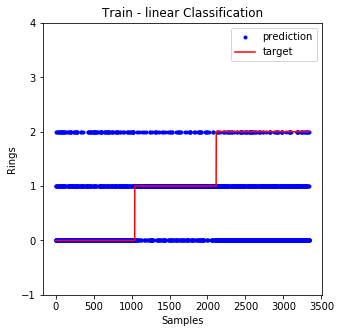

In [107]:
TtrainL = np.argmax(Ttrain, axis=1)

plot_result(Ltrain_llr, TtrainL, title="Train - linear Classification")

Acc: 51.25748502994012 %


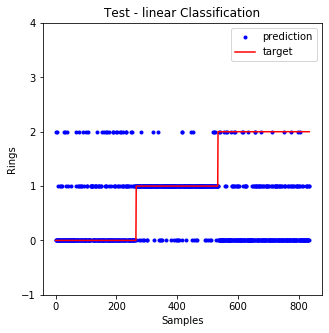

In [108]:
# Test results 
TtestL = np.argmax(Ttest, axis=1)

plot_result(Ltest_llr, TtestL, title="Test - linear Classification")

Here we can see our results aren't great. Let's see if nonlinear classification helps out at all!

# Apply Nonlinear Classification: Neural Networks

Just like nonlinear regression the backwards and forwards passes will remain the same. There is one slight change to the forward pass of course. This change is applying the softmax to out predictions $Y$. Luckily, applying the softmax does not change our equations for the backwards pass!

Here, we'll once again work with a very basic neural network with one hidden layer.


## Variables 

Here is a list of the variables,  shapes, and their description.

- $X : N \times D$ - Input Data without bias
    - $N$ is the number of data samples
    - $D$ is the number of features
- $X1 : N \times (D+1)$ - Input data with bias
    - $(D+1)$ is the number of features plus bias
- $V : (D+1) \times G$ - Input weights
    - Note: $G$ is the number of hidden units
- $Z : N \times G$ - First layer output
    - Note: Activation function is applied here
- $Z1 : N \times (G+1)$ - First layer output with bias
    - $(G+1)$ is the number of hidden units plus bias
- $W : (G+1) \times K$ - Output weights
    - $K$ is the number of outputs (for regression this is 1 and for classification this your number of classes)
- $Y : N \times K$ - Predictions
- $T : N \times K$ - Targets

## Forward Pass Steps

Recall the following steps for making a prediction, also called the forward pass, from the class notes.

1. Calculate first layer output by taking the dot product between the inputs $X1$ and input weights $V$. Then apply the activation function $\tanh$. 
$$Z = \tanh(X1 \cdot V)$$
2. Add bias to $Z$ to get $Z1$
3. Make your predictions by taking the dot product between the output of the first layer $Z1$ and the output weights $W$.
$$Y = Z1 \cdot W$$
4. Apply the softmax to your predictions
$$Y = softmax(Y)$$


## Backward Pass Equations

Recall the backward pass weight updates for $V$ and $W$ from the class notes.

$$ V \leftarrow V + \frac{\rho_v}{N*K}*{X1}^T \cdot ( (T - Y) \cdot W^T \odot (1 - Z^2) )$$

Here $N$ and $K$ are scalars and $\rho_v$ is our learning rate for our input weights $V$. In addition, $X1$ is our input data with bias added, $T$ is our target, $Y$ is our predictions, $W$ is the output weights, and $Z$ is the output of the first layer with the activation function applied. **Recall, that we remove the bias from $W$ for this update as we only take into account the bias for the current weight we are updating! (In the case, since we updating $V$, we only care about the bias for input weight $V$.)**

$$ W \leftarrow W + \frac{\rho_w}{N*K}*{Z1}^T \cdot (T - Y)$$

Here $N$ and $K$ are scalars and $\rho_w$ is our learning rate for our output weights $W$. In addition, $T$ is our target, $Y$ is our predictions, $Z1$ is the output of the first layer with the activation function applied and bias added. 

**Note that $\cdot$ refers to the dot product, $\odot$ refers to the element-wise multiplication, and $*$ refers to scalar multiplication.**

### TODO: 

Now, let's try to classify with neural networks. Fill in the TODO blank to finish the code for nonlinear logistic regression. We have done the forward pass for you. All forward pass code is contained inside the `predict()` function.

**Backward pass TODOs:**

**Hint: Use the Backward Pass Equations section above!**

1. Calculate the update for the input weights $V$. Here $\frac{\rho_v}{N*K}$ corresponds to `rho_v_scaled`, $X1$ corresponds to ` X1strain`, $(T - Y)$ corresponds to `error`, $W$ corresponds to `W`, and $Z$ corresponds to `Z`.  Update the value stored in `V`.
    1. Hint: If you are getting `ValueError: operands could not be broadcast together with shapes ...` this is because $(T - Y) \cdot W^T$ produces a matrix with the shape $N \times (G+1)$ and $(1-Z^2)$ has a shape$N \times G$. Thus, $ (T - Y) \cdot W^T \odot (1 - Z^2)$ will have incompatible shapes for element-wise multiplication.  Remember, we must remove bias from the weight $W$ for this update. Try indexing everything but the first column of $W$.
<br><br>
2. Calculate the update for the output weights $W$. Here $Z1$ corresponds to `Z1` and $(T - Y)$ corresponds to `error` and $\frac{\rho_w}{N*K}$ refers to `rho_w_scaled`. Update the value stored in `W`.

In [109]:
# Compute negative log loss (minimize negative log likelihood)
def cross_entropy_loss (Y, T):
    loss_vector = T * -np.log(Y)
    total_loss =  np.sum(loss_vector)
    return total_loss

In [110]:
def predict(Xs, V, W):
    X1 = addOnes(Xs)
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = g(Z1, W)
    return Y, np.argmax(Y, axis=1), X1, Z1

In [111]:
# Now, set the number of outputs, K
K = Ttrain.shape[1] if len(Ttrain.shape) == 2 else 1

# Set parameters of neural network
hidden_units = 10
rho_v = 0.1
rho_w = 0.1
rho_v_scaled = rho_v / (Ntrain*K)
rho_w_scaled = rho_w / (Ntrain*K)

# Determine how many steepest descent steps to take when searching the mean-squared-error loss space
steps = 5000

###########################################################################
# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(D+1,hidden_units))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+hidden_units,K))-0.5)

###########################################################################
# collect training and testing errors for plotting
errorTrace = np.zeros((steps,2))

fig = plt.figure(figsize=(10,8))
for s in range(steps):
    # Forward pass
    Ytrain, YtrL, X1, Z1 = predict(XtrainS, V, W)
    Z = Z1[:, 1:] # Remove bias from Z1

    # Error in output
    error = Ttrain - Ytrain

    # TODO: Backward pass - the backpropagation and weight update steps
    # TODO (1)
    V = 
    # TODO (2)
    W = 

    # error traces for plotting
    errorTrace[s,0] = cross_entropy_loss(Ytrain, Ttrain) 
    Ytest, YteL, _, _ =  predict(XtestS, V, W)
    errorTrace[s,1] = cross_entropy_loss(Ytest, Ttest)

print("Done!")    

Done!


<Figure size 720x576 with 0 Axes>

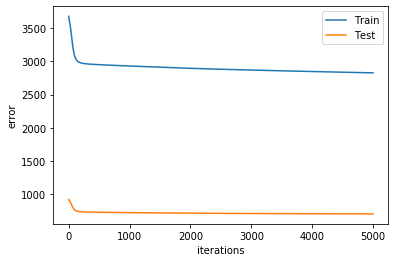

In [112]:
plt.plot(errorTrace)
plt.legend(('Train','Test'))
plt.xlabel("iterations")
plt.ylabel("error");

Now let's compute our predictions for our train and test data.

In [113]:
_, Ltrain_nn, _, _ = predict(XtrainS, V, W)
_, Ltest_nn, _, _ = predict(XtestS, V, W)

Acc: 56.193895870736085 %


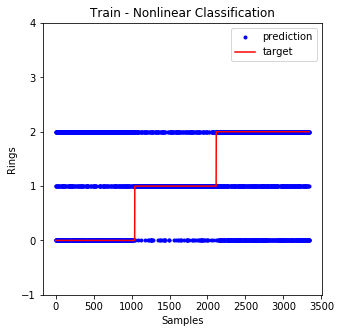

In [114]:
plot_result(Ltrain_nn, TtrainL, title="Train - Nonlinear Classification")

Acc: 57.48502994011976 %


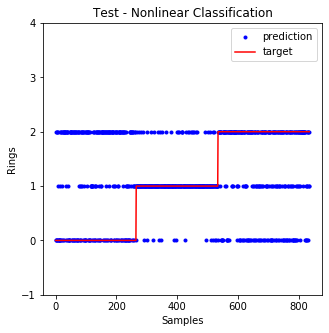

In [121]:
plot_result(Ltest_nn, TtestL, title="Test - Nonlinear Classification")

Well, for an unoptimized shallow neural network these aren't the worst results. However, we might be able to do much better if we preform a search for better hyperparameters. For instance, maybe our learning rate is too high, or many we need more hidden units or layers. Now would be a good time to use cross-validation in combination with a parameter search to find the optimal data split and parameters.

# Analysis: 

What do you think about the model? Compared to the linear regression, does it fit better? 

Acc: 51.25748502994012 %


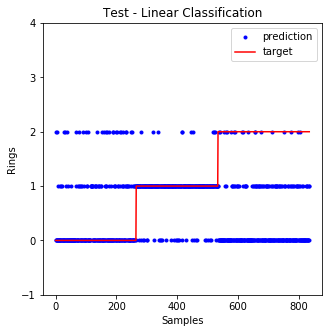

In [118]:
plot_result(Ltest_llr, TtestL, title="Test - Linear Classification")

Acc: 57.48502994011976 %


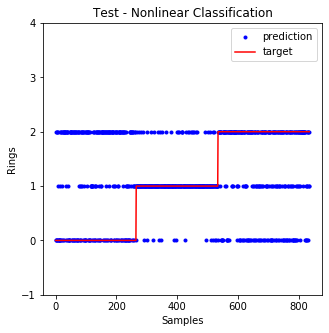

In [120]:
plot_result(Ltest_nn, TtestL, title="Test - Nonlinear Classification")

### BONUS TODO (1): 
You may think nonlinear classification is better, but not by much. 

Try adjusting the number of hidden units by changing the value of `hidden_units` to 10, 50, and 100. Do you notice any differences in the test loss and plots? 

### BONUS TODO (2):
Now, let's try stopping a bit earlier. Let's try to stop before our test error increases while training error still decreases, as this is sign of overfitting.

Try decreasing the number of gradient decent steps by adjusting the `steps` variable. Try using 15k, 5k, and 500. Notice any changes in the prediction plots?

### BONUS TODO (3):

Well now instead of manually changing the parameters try implementing cross-validation to test which data partitions work the best. In the inner most for loop you can try adding parameter searches for hyperparameters such as `steps` and `hidden_units`.